#Import Libraries

In [1]:
!pip install Boruta
!pip install imblearn

     |████████████████████████████████| 61kB 2.9MB/s 


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import tensorflow as tf
from boruta import BorutaPy
from collections import Counter
from google.colab import files
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_curve, auc, mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow import keras

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


##Import Dataset

In [3]:
uploaded = files.upload()

Saving Data copy.csv to Data copy.csv


In [4]:
df = pd.read_csv('Data copy.csv')
df_new = df[:1000]
df_new.head()

,PrimaryMrn,PatientAge,PatientSex,Ethnicity,PatientRace,PayorFinancialClass,EdDisposition,ArrivalInstant,DepartureInstant,PrimaryChiefComplaint,EDLengthofStayInMins,PatientClass,FirstAttendingProviderType,ArrivalDayOfWeek,ED_First_HR,ED_First_Temp,ED_First_RespRate,ED_First_SpO2,BP_SYS_LAST,BP_DIA_LAST,SMOKING_USER_YN,USES_ANY_TOBAC_YN,HDL_LAST,TTL_CHL_LAST,ON_ANTHYPERT_YN,HAS_ABDOM_AORTIC_ANEURYSM_YN,HAS_AFIB_YN,HAS_ALCOHOLISM_YN,HAS_ANEMIA_YN,HAS_ASTHMA_YN,HAS_BREAST_CANCER_YN,HAS_CAD_YN,HAS_CHF_YN,HAS_CHRONIC_HEART_DISEASE_YN,HAS_CHRONIC_LIVER_DISEASE_YN,HAS_CHRONIC_LUNG_DISEASE_YN,HAS_CKD_YN,HAS_COPD_YN,HAS_CVD_YN,HAS_DIABETES_YN,HAS_TYP_2_DIABETES_YN,HAS_HYPERTENSION_YN,HAS_HEMOGLOBINOPATHIES_YN,HAS_LIPID_DISORDER_YN,HAS_NEPHROTIC_SYNDROME_YN,HAS_PERIPH_VASC_DIS_YN,HAD_HEART_ATTACK_YN,HAS_OBESITY_YN,ED_RBC,ED_WBC,ED_PLT,ED_HCT,ED_HGB,ED_MCH,ED_MCHPCT,ED_MCV,ED_RCDW,ED_ANION,ED_BUN,ED_CA,ED_GLU,ED_CL,ED_CO2,ED_CREA,ED_K,ED_NA,ED_GFR_AA,ED_GFR_NAA,PrimaryDiagnosisName
0,62193221,53,Male,Not Hispanic/Latino,White,Commercial,Admit,1/1/17 15:38,1/1/17 18:41,CHEST PAIN,183,Inpatient,Physician,Sunday,62.0,97.7,24.0,92.0,106.0,77.0,N,N,28.0,104.0,Y,N,Y,N,N,N,N,N,Y,Y,N,Y,Y,Y,Y,N,N,Y,N,N,N,N,N,Y,4.88,5.1,157.0,33.8,10.4,21.4,30.9,69.3,18.5,10.0,32.0,9.5,89.0,107.0,25.0,1.55,3.7,142.0,45.0,39.0,NSTEMI
1,50823856,57,Male,Hispanic or Latino,White,HAP,Place in Observation,1/1/17 18:22,1/2/17 3:13,CHEST PAIN,531,Inpatient,Physician,Sunday,93.0,99.5,18.0,98.0,118.0,82.0,N,N,NaN,NaN,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,5.21,5.1,210.0,46.1,16.0,30.7,34.7,88.5,12.7,10.0,18.0,9.5,106.0,107.0,23.0,0.90,3.9,140.0,120.0,113.0,NSTEMI
2,37281865,61,Male,Not Hispanic/Latino,Black,Blue Shield,Admit,1/2/17 10:59,1/2/17 18:31,CHEST PAIN,452,Inpatient,Physician,Monday,73.0,97.7,18.0,99.0,117.0,71.0,N,N,36.0,179.0,Y,N,N,N,N,Y,N,N,N,N,N,N,Y,N,N,Y,Y,Y,N,N,N,N,N,N,6.21,11.1,271.0,42.0,13.2,21.2,31.3,67.7,14.4,12.0,23.0,9.7,106.0,102.0,22.0,0.62,3.4,136.0,120.0,104.0,NSTEMI
3,19449449,58,Male,Not Hispanic/Latino,Black,MEDICAID HMO,Admit,1/3/17 13:43,1/4/17 1:44,CHEST PAIN,721,Inpatient,Physician,Tuesday,79.0,97.5,20.0,96.0,115.0,68.0,N,N,41.0,170.0,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,4.72,6.1,124.0,45.1,15.3,32.4,33.8,95.6,12.3,10.0,19.0,8.8,106.0,106.0,24.0,0.93,4.4,140.0,99.0,86.0,NSTEMI
4,7310082,66,Male,Not Hispanic/Latino,Black,MEDICARE ADVANTAGE,Admit,1/7/17 18:31,1/8/17 1:03,CHEST PAIN,392,Observation,Physician,Saturday,66.0,97.3,22.0,100.0,117.0,52.0,N,N,71.0,207.0,Y,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,Y,4.03,8.4,296.0,36.6,12.5,31.1,34.2,90.9,13.2,10.0,15.0,9.7,138.0,105.0,24.0,0.94,3.5,139.0,79.0,68.0,UA


In [5]:
df_new['new_PrimaryDiagnosisName'] = np.where(df_new['PrimaryDiagnosisName'] != 'UA', 1, 0)
df_new = df_new.drop(['PrimaryDiagnosisName'], axis=1)
df_new.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,PrimaryMrn,PatientAge,PatientSex,Ethnicity,PatientRace,PayorFinancialClass,EdDisposition,ArrivalInstant,DepartureInstant,PrimaryChiefComplaint,EDLengthofStayInMins,PatientClass,FirstAttendingProviderType,ArrivalDayOfWeek,ED_First_HR,ED_First_Temp,ED_First_RespRate,ED_First_SpO2,BP_SYS_LAST,BP_DIA_LAST,SMOKING_USER_YN,USES_ANY_TOBAC_YN,HDL_LAST,TTL_CHL_LAST,ON_ANTHYPERT_YN,HAS_ABDOM_AORTIC_ANEURYSM_YN,HAS_AFIB_YN,HAS_ALCOHOLISM_YN,HAS_ANEMIA_YN,HAS_ASTHMA_YN,HAS_BREAST_CANCER_YN,HAS_CAD_YN,HAS_CHF_YN,HAS_CHRONIC_HEART_DISEASE_YN,HAS_CHRONIC_LIVER_DISEASE_YN,HAS_CHRONIC_LUNG_DISEASE_YN,HAS_CKD_YN,HAS_COPD_YN,HAS_CVD_YN,HAS_DIABETES_YN,HAS_TYP_2_DIABETES_YN,HAS_HYPERTENSION_YN,HAS_HEMOGLOBINOPATHIES_YN,HAS_LIPID_DISORDER_YN,HAS_NEPHROTIC_SYNDROME_YN,HAS_PERIPH_VASC_DIS_YN,HAD_HEART_ATTACK_YN,HAS_OBESITY_YN,ED_RBC,ED_WBC,ED_PLT,ED_HCT,ED_HGB,ED_MCH,ED_MCHPCT,ED_MCV,ED_RCDW,ED_ANION,ED_BUN,ED_CA,ED_GLU,ED_CL,ED_CO2,ED_CREA,ED_K,ED_NA,ED_GFR_AA,ED_GFR_NAA,new_PrimaryDiagnosisName
0,62193221,53,Male,Not Hispanic/Latino,White,Commercial,Admit,1/1/17 15:38,1/1/17 18:41,CHEST PAIN,183,Inpatient,Physician,Sunday,62.0,97.7,24.0,92.0,106.0,77.0,N,N,28.0,104.0,Y,N,Y,N,N,N,N,N,Y,Y,N,Y,Y,Y,Y,N,N,Y,N,N,N,N,N,Y,4.88,5.1,157.0,33.8,10.4,21.4,30.9,69.3,18.5,10.0,32.0,9.5,89.0,107.0,25.0,1.55,3.7,142.0,45.0,39.0,1
1,50823856,57,Male,Hispanic or Latino,White,HAP,Place in Observation,1/1/17 18:22,1/2/17 3:13,CHEST PAIN,531,Inpatient,Physician,Sunday,93.0,99.5,18.0,98.0,118.0,82.0,N,N,NaN,NaN,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,5.21,5.1,210.0,46.1,16.0,30.7,34.7,88.5,12.7,10.0,18.0,9.5,106.0,107.0,23.0,0.90,3.9,140.0,120.0,113.0,1
2,37281865,61,Male,Not Hispanic/Latino,Black,Blue Shield,Admit,1/2/17 10:59,1/2/17 18:31,CHEST PAIN,452,Inpatient,Physician,Monday,73.0,97.7,18.0,99.0,117.0,71.0,N,N,36.0,179.0,Y,N,N,N,N,Y,N,N,N,N,N,N,Y,N,N,Y,Y,Y,N,N,N,N,N,N,6.21,11.1,271.0,42.0,13.2,21.2,31.3,67.7,14.4,12.0,23.0,9.7,106.0,102.0,22.0,0.62,3.4,136.0,120.0,104.0,1
3,19449449,58,Male,Not Hispanic/Latino,Black,MEDICAID HMO,Admit,1/3/17 13:43,1/4/17 1:44,CHEST PAIN,721,Inpatient,Physician,Tuesday,79.0,97.5,20.0,96.0,115.0,68.0,N,N,41.0,170.0,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,4.72,6.1,124.0,45.1,15.3,32.4,33.8,95.6,12.3,10.0,19.0,8.8,106.0,106.0,24.0,0.93,4.4,140.0,99.0,86.0,1
4,7310082,66,Male,Not Hispanic/Latino,Black,MEDICARE ADVANTAGE,Admit,1/7/17 18:31,1/8/17 1:03,CHEST PAIN,392,Observation,Physician,Saturday,66.0,97.3,22.0,100.0,117.0,52.0,N,N,71.0,207.0,Y,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,Y,4.03,8.4,296.0,36.6,12.5,31.1,34.2,90.9,13.2,10.0,15.0,9.7,138.0,105.0,24.0,0.94,3.5,139.0,79.0,68.0,0


In [6]:
#Shape of Dataframe
df_new.shape

(1000, 69)

In [7]:
#Identify the target column
df_new.new_PrimaryDiagnosisName
df_new.new_PrimaryDiagnosisName.to_csv('P4_file.csv')

In [8]:
#Imbalance Check
df_new.new_PrimaryDiagnosisName.value_counts()

1    638
0    362
Name: new_PrimaryDiagnosisName, dtype: int64

# Data Analysis

In [9]:
X = df_new.drop(['new_PrimaryDiagnosisName','PrimaryMrn', 'Ethnicity', 'PayorFinancialClass',	'ArrivalInstant',	'DepartureInstant',
              'FirstAttendingProviderType'], axis=1)
y = df_new.new_PrimaryDiagnosisName

In [10]:
X.head()

,PatientAge,PatientSex,PatientRace,EdDisposition,PrimaryChiefComplaint,EDLengthofStayInMins,PatientClass,ArrivalDayOfWeek,ED_First_HR,ED_First_Temp,ED_First_RespRate,ED_First_SpO2,BP_SYS_LAST,BP_DIA_LAST,SMOKING_USER_YN,USES_ANY_TOBAC_YN,HDL_LAST,TTL_CHL_LAST,ON_ANTHYPERT_YN,HAS_ABDOM_AORTIC_ANEURYSM_YN,HAS_AFIB_YN,HAS_ALCOHOLISM_YN,HAS_ANEMIA_YN,HAS_ASTHMA_YN,HAS_BREAST_CANCER_YN,HAS_CAD_YN,HAS_CHF_YN,HAS_CHRONIC_HEART_DISEASE_YN,HAS_CHRONIC_LIVER_DISEASE_YN,HAS_CHRONIC_LUNG_DISEASE_YN,HAS_CKD_YN,HAS_COPD_YN,HAS_CVD_YN,HAS_DIABETES_YN,HAS_TYP_2_DIABETES_YN,HAS_HYPERTENSION_YN,HAS_HEMOGLOBINOPATHIES_YN,HAS_LIPID_DISORDER_YN,HAS_NEPHROTIC_SYNDROME_YN,HAS_PERIPH_VASC_DIS_YN,HAD_HEART_ATTACK_YN,HAS_OBESITY_YN,ED_RBC,ED_WBC,ED_PLT,ED_HCT,ED_HGB,ED_MCH,ED_MCHPCT,ED_MCV,ED_RCDW,ED_ANION,ED_BUN,ED_CA,ED_GLU,ED_CL,ED_CO2,ED_CREA,ED_K,ED_NA,ED_GFR_AA,ED_GFR_NAA
0,53,Male,White,Admit,CHEST PAIN,183,Inpatient,Sunday,62.0,97.7,24.0,92.0,106.0,77.0,N,N,28.0,104.0,Y,N,Y,N,N,N,N,N,Y,Y,N,Y,Y,Y,Y,N,N,Y,N,N,N,N,N,Y,4.88,5.1,157.0,33.8,10.4,21.4,30.9,69.3,18.5,10.0,32.0,9.5,89.0,107.0,25.0,1.55,3.7,142.0,45.0,39.0
1,57,Male,White,Place in Observation,CHEST PAIN,531,Inpatient,Sunday,93.0,99.5,18.0,98.0,118.0,82.0,N,N,NaN,NaN,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,5.21,5.1,210.0,46.1,16.0,30.7,34.7,88.5,12.7,10.0,18.0,9.5,106.0,107.0,23.0,0.90,3.9,140.0,120.0,113.0
2,61,Male,Black,Admit,CHEST PAIN,452,Inpatient,Monday,73.0,97.7,18.0,99.0,117.0,71.0,N,N,36.0,179.0,Y,N,N,N,N,Y,N,N,N,N,N,N,Y,N,N,Y,Y,Y,N,N,N,N,N,N,6.21,11.1,271.0,42.0,13.2,21.2,31.3,67.7,14.4,12.0,23.0,9.7,106.0,102.0,22.0,0.62,3.4,136.0,120.0,104.0
3,58,Male,Black,Admit,CHEST PAIN,721,Inpatient,Tuesday,79.0,97.5,20.0,96.0,115.0,68.0,N,N,41.0,170.0,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,4.72,6.1,124.0,45.1,15.3,32.4,33.8,95.6,12.3,10.0,19.0,8.8,106.0,106.0,24.0,0.93,4.4,140.0,99.0,86.0
4,66,Male,Black,Admit,CHEST PAIN,392,Observation,Saturday,66.0,97.3,22.0,100.0,117.0,52.0,N,N,71.0,207.0,Y,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,Y,4.03,8.4,296.0,36.6,12.5,31.1,34.2,90.9,13.2,10.0,15.0,9.7,138.0,105.0,24.0,0.94,3.5,139.0,79.0,68.0


In [11]:
X.shape, y.shape

((1000, 62), (1000,))

#Preprocessing the Data

In [12]:
# IMPORTANT: Convert entire dataframe to Integer/Float Data Type
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 62 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PatientAge                    1000 non-null   int64  
 1   PatientSex                    1000 non-null   object 
 2   PatientRace                   1000 non-null   object 
 3   EdDisposition                 1000 non-null   object 
 4   PrimaryChiefComplaint         1000 non-null   object 
 5   EDLengthofStayInMins          1000 non-null   int64  
 6   PatientClass                  1000 non-null   object 
 7   ArrivalDayOfWeek              1000 non-null   object 
 8   ED_First_HR                   999 non-null    float64
 9   ED_First_Temp                 986 non-null    float64
 10  ED_First_RespRate             999 non-null    float64
 11  ED_First_SpO2                 999 non-null    float64
 12  BP_SYS_LAST                   998 non-null    float64
 13  BP_D

In [13]:
X_cat = X.select_dtypes(include=[object])
X_cat

,PatientSex,PatientRace,EdDisposition,PrimaryChiefComplaint,PatientClass,ArrivalDayOfWeek,SMOKING_USER_YN,USES_ANY_TOBAC_YN,ON_ANTHYPERT_YN,HAS_ABDOM_AORTIC_ANEURYSM_YN,HAS_AFIB_YN,HAS_ALCOHOLISM_YN,HAS_ANEMIA_YN,HAS_ASTHMA_YN,HAS_BREAST_CANCER_YN,HAS_CAD_YN,HAS_CHF_YN,HAS_CHRONIC_HEART_DISEASE_YN,HAS_CHRONIC_LIVER_DISEASE_YN,HAS_CHRONIC_LUNG_DISEASE_YN,HAS_CKD_YN,HAS_COPD_YN,HAS_CVD_YN,HAS_DIABETES_YN,HAS_TYP_2_DIABETES_YN,HAS_HYPERTENSION_YN,HAS_HEMOGLOBINOPATHIES_YN,HAS_LIPID_DISORDER_YN,HAS_NEPHROTIC_SYNDROME_YN,HAS_PERIPH_VASC_DIS_YN,HAD_HEART_ATTACK_YN,HAS_OBESITY_YN
0,Male,White,Admit,CHEST PAIN,Inpatient,Sunday,N,N,Y,N,Y,N,N,N,N,N,Y,Y,N,Y,Y,Y,Y,N,N,Y,N,N,N,N,N,Y
1,Male,White,Place in Observation,CHEST PAIN,Inpatient,Sunday,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
2,Male,Black,Admit,CHEST PAIN,Inpatient,Monday,N,N,Y,N,N,N,N,Y,N,N,N,N,N,N,Y,N,N,Y,Y,Y,N,N,N,N,N,N
3,Male,Black,Admit,CHEST PAIN,Inpatient,Tuesday,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N
4,Male,Black,Admit,CHEST PAIN,Observation,Saturday,N,N,Y,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Female,Black,Admit,CHEST PAIN,Inpatient,Tuesday,Y,Y,Y,N,N,Y,Y,N,N,N,N,N,Y,Y,Y,Y,Y,N,N,Y,N,N,N,N,N,N
996,Male,Black,Admit,ALTERED MENTAL STATUS,Inpatient,Tuesday,N,N,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N
997,Male,White,Admit,CHEST PAIN,Inpatient,Tuesday,NaN,NaN,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
998,Male,Black,Admit,CHEST PAIN,Inpatient,Wednesday,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N


In [14]:
X.PatientRace.value_counts()

Black                            709
White                            208
Other                             46
Decline                           12
Do Not Know                       10
Asian                              7
Hispanic                           3
American Indian/Alaska Native      3
Middle Eastern                     2
Name: PatientRace, dtype: int64

In [15]:
X.PrimaryChiefComplaint.value_counts()

CHEST PAIN                581
SHORTNESS OF BREATH       130
OTHER                      30
PAIN                       17
ABDOMINAL PAIN             14
                         ... 
FAILURE TO THRIVE           1
PSYCHIATRIC EVALUATION      1
NASAL CONGESTION            1
PLEURISY                    1
HYPOGLYCEMIA                1
Name: PrimaryChiefComplaint, Length: 81, dtype: int64

In [16]:
type(X), X.shape

(pandas.core.frame.DataFrame, (1000, 62))

#One Hot Encoding

In [17]:
## Let's find the most frequent categories for RACE
top_1 = [x for x in X.PrimaryChiefComplaint.value_counts().sort_values(ascending=False).head(10).index]
top_1

['CHEST PAIN',
 'SHORTNESS OF BREATH',
 'OTHER',
 'PAIN',
 'ABDOMINAL PAIN',
 'DIZZINESS',
 'COUGH',
 'HYPERTENSION',
 'ER EVAL',
 'FALL']

In [18]:
# making 10 binary variables
for label in top_1:
    X[label] = np.where(X['PrimaryChiefComplaint']==label,1,0)
X[['PrimaryChiefComplaint']+top_1]

,PrimaryChiefComplaint,CHEST PAIN,SHORTNESS OF BREATH,OTHER,PAIN,ABDOMINAL PAIN,DIZZINESS,COUGH,HYPERTENSION,ER EVAL,FALL
0,CHEST PAIN,1,0,0,0,0,0,0,0,0,0
1,CHEST PAIN,1,0,0,0,0,0,0,0,0,0
2,CHEST PAIN,1,0,0,0,0,0,0,0,0,0
3,CHEST PAIN,1,0,0,0,0,0,0,0,0,0
4,CHEST PAIN,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
995,CHEST PAIN,1,0,0,0,0,0,0,0,0,0
996,ALTERED MENTAL STATUS,0,0,0,0,0,0,0,0,0,0
997,CHEST PAIN,1,0,0,0,0,0,0,0,0,0
998,CHEST PAIN,1,0,0,0,0,0,0,0,0,0


In [19]:
def one_hot_top_x(df_b, variable, top_x_labels):
    for label in top_x_labels:
        df[variable+'_'+label] = np.where(df[variable]==label, 1, 0)

one_hot_top_x(X, 'PrimaryChiefComplaint', top_1)
X.head()

,PatientAge,PatientSex,PatientRace,EdDisposition,PrimaryChiefComplaint,EDLengthofStayInMins,PatientClass,ArrivalDayOfWeek,ED_First_HR,ED_First_Temp,ED_First_RespRate,ED_First_SpO2,BP_SYS_LAST,BP_DIA_LAST,SMOKING_USER_YN,USES_ANY_TOBAC_YN,HDL_LAST,TTL_CHL_LAST,ON_ANTHYPERT_YN,HAS_ABDOM_AORTIC_ANEURYSM_YN,HAS_AFIB_YN,HAS_ALCOHOLISM_YN,HAS_ANEMIA_YN,HAS_ASTHMA_YN,HAS_BREAST_CANCER_YN,HAS_CAD_YN,HAS_CHF_YN,HAS_CHRONIC_HEART_DISEASE_YN,HAS_CHRONIC_LIVER_DISEASE_YN,HAS_CHRONIC_LUNG_DISEASE_YN,HAS_CKD_YN,HAS_COPD_YN,HAS_CVD_YN,HAS_DIABETES_YN,HAS_TYP_2_DIABETES_YN,HAS_HYPERTENSION_YN,HAS_HEMOGLOBINOPATHIES_YN,HAS_LIPID_DISORDER_YN,HAS_NEPHROTIC_SYNDROME_YN,HAS_PERIPH_VASC_DIS_YN,HAD_HEART_ATTACK_YN,HAS_OBESITY_YN,ED_RBC,ED_WBC,ED_PLT,ED_HCT,ED_HGB,ED_MCH,ED_MCHPCT,ED_MCV,ED_RCDW,ED_ANION,ED_BUN,ED_CA,ED_GLU,ED_CL,ED_CO2,ED_CREA,ED_K,ED_NA,ED_GFR_AA,ED_GFR_NAA,CHEST PAIN,SHORTNESS OF BREATH,OTHER,PAIN,ABDOMINAL PAIN,DIZZINESS,COUGH,HYPERTENSION,ER EVAL,FALL
0,53,Male,White,Admit,CHEST PAIN,183,Inpatient,Sunday,62.0,97.7,24.0,92.0,106.0,77.0,N,N,28.0,104.0,Y,N,Y,N,N,N,N,N,Y,Y,N,Y,Y,Y,Y,N,N,Y,N,N,N,N,N,Y,4.88,5.1,157.0,33.8,10.4,21.4,30.9,69.3,18.5,10.0,32.0,9.5,89.0,107.0,25.0,1.55,3.7,142.0,45.0,39.0,1,0,0,0,0,0,0,0,0,0
1,57,Male,White,Place in Observation,CHEST PAIN,531,Inpatient,Sunday,93.0,99.5,18.0,98.0,118.0,82.0,N,N,NaN,NaN,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,5.21,5.1,210.0,46.1,16.0,30.7,34.7,88.5,12.7,10.0,18.0,9.5,106.0,107.0,23.0,0.90,3.9,140.0,120.0,113.0,1,0,0,0,0,0,0,0,0,0
2,61,Male,Black,Admit,CHEST PAIN,452,Inpatient,Monday,73.0,97.7,18.0,99.0,117.0,71.0,N,N,36.0,179.0,Y,N,N,N,N,Y,N,N,N,N,N,N,Y,N,N,Y,Y,Y,N,N,N,N,N,N,6.21,11.1,271.0,42.0,13.2,21.2,31.3,67.7,14.4,12.0,23.0,9.7,106.0,102.0,22.0,0.62,3.4,136.0,120.0,104.0,1,0,0,0,0,0,0,0,0,0
3,58,Male,Black,Admit,CHEST PAIN,721,Inpatient,Tuesday,79.0,97.5,20.0,96.0,115.0,68.0,N,N,41.0,170.0,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,4.72,6.1,124.0,45.1,15.3,32.4,33.8,95.6,12.3,10.0,19.0,8.8,106.0,106.0,24.0,0.93,4.4,140.0,99.0,86.0,1,0,0,0,0,0,0,0,0,0
4,66,Male,Black,Admit,CHEST PAIN,392,Observation,Saturday,66.0,97.3,22.0,100.0,117.0,52.0,N,N,71.0,207.0,Y,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,Y,4.03,8.4,296.0,36.6,12.5,31.1,34.2,90.9,13.2,10.0,15.0,9.7,138.0,105.0,24.0,0.94,3.5,139.0,79.0,68.0,1,0,0,0,0,0,0,0,0,0


In [20]:
# drop PrimaryChiefComplaint column to prevent dummy variables trap
X.drop(['PrimaryChiefComplaint'], axis=1, inplace=True)

In [21]:
X

,PatientAge,PatientSex,PatientRace,EdDisposition,EDLengthofStayInMins,PatientClass,ArrivalDayOfWeek,ED_First_HR,ED_First_Temp,ED_First_RespRate,ED_First_SpO2,BP_SYS_LAST,BP_DIA_LAST,SMOKING_USER_YN,USES_ANY_TOBAC_YN,HDL_LAST,TTL_CHL_LAST,ON_ANTHYPERT_YN,HAS_ABDOM_AORTIC_ANEURYSM_YN,HAS_AFIB_YN,HAS_ALCOHOLISM_YN,HAS_ANEMIA_YN,HAS_ASTHMA_YN,HAS_BREAST_CANCER_YN,HAS_CAD_YN,HAS_CHF_YN,HAS_CHRONIC_HEART_DISEASE_YN,HAS_CHRONIC_LIVER_DISEASE_YN,HAS_CHRONIC_LUNG_DISEASE_YN,HAS_CKD_YN,HAS_COPD_YN,HAS_CVD_YN,HAS_DIABETES_YN,HAS_TYP_2_DIABETES_YN,HAS_HYPERTENSION_YN,HAS_HEMOGLOBINOPATHIES_YN,HAS_LIPID_DISORDER_YN,HAS_NEPHROTIC_SYNDROME_YN,HAS_PERIPH_VASC_DIS_YN,HAD_HEART_ATTACK_YN,HAS_OBESITY_YN,ED_RBC,ED_WBC,ED_PLT,ED_HCT,ED_HGB,ED_MCH,ED_MCHPCT,ED_MCV,ED_RCDW,ED_ANION,ED_BUN,ED_CA,ED_GLU,ED_CL,ED_CO2,ED_CREA,ED_K,ED_NA,ED_GFR_AA,ED_GFR_NAA,CHEST PAIN,SHORTNESS OF BREATH,OTHER,PAIN,ABDOMINAL PAIN,DIZZINESS,COUGH,HYPERTENSION,ER EVAL,FALL
0,53,Male,White,Admit,183,Inpatient,Sunday,62.0,97.7,24.0,92.0,106.0,77.0,N,N,28.0,104.0,Y,N,Y,N,N,N,N,N,Y,Y,N,Y,Y,Y,Y,N,N,Y,N,N,N,N,N,Y,4.88,5.1,157.0,33.8,10.4,21.4,30.9,69.3,18.5,10.0,32.0,9.5,89.0,107.0,25.0,1.55,3.7,142.0,45.0,39.0,1,0,0,0,0,0,0,0,0,0
1,57,Male,White,Place in Observation,531,Inpatient,Sunday,93.0,99.5,18.0,98.0,118.0,82.0,N,N,NaN,NaN,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,5.21,5.1,210.0,46.1,16.0,30.7,34.7,88.5,12.7,10.0,18.0,9.5,106.0,107.0,23.0,0.90,3.9,140.0,120.0,113.0,1,0,0,0,0,0,0,0,0,0
2,61,Male,Black,Admit,452,Inpatient,Monday,73.0,97.7,18.0,99.0,117.0,71.0,N,N,36.0,179.0,Y,N,N,N,N,Y,N,N,N,N,N,N,Y,N,N,Y,Y,Y,N,N,N,N,N,N,6.21,11.1,271.0,42.0,13.2,21.2,31.3,67.7,14.4,12.0,23.0,9.7,106.0,102.0,22.0,0.62,3.4,136.0,120.0,104.0,1,0,0,0,0,0,0,0,0,0
3,58,Male,Black,Admit,721,Inpatient,Tuesday,79.0,97.5,20.0,96.0,115.0,68.0,N,N,41.0,170.0,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,4.72,6.1,124.0,45.1,15.3,32.4,33.8,95.6,12.3,10.0,19.0,8.8,106.0,106.0,24.0,0.93,4.4,140.0,99.0,86.0,1,0,0,0,0,0,0,0,0,0
4,66,Male,Black,Admit,392,Observation,Saturday,66.0,97.3,22.0,100.0,117.0,52.0,N,N,71.0,207.0,Y,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,Y,4.03,8.4,296.0,36.6,12.5,31.1,34.2,90.9,13.2,10.0,15.0,9.7,138.0,105.0,24.0,0.94,3.5,139.0,79.0,68.0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,63,Female,Black,Admit,339,Inpatient,Tuesday,122.0,97.5,18.0,100.0,146.0,90.0,Y,Y,79.0,109.0,Y,N,N,Y,Y,N,N,N,N,N,Y,Y,Y,Y,Y,N,N,Y,N,N,N,N,N,N,5.07,6.2,267.0,41.6,14.1,27.8,33.9,82.1,15.2,17.0,13.0,9.2,109.0,90.0,21.0,1.42,3.7,128.0,48.0,41.0,1,0,0,0,0,0,0,0,0,0
996,95,Male,Black,Admit,507,Inpatient,Tuesday,117.0,98.6,20.0,100.0,156.0,106.0,N,N,35.0,205.0,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,5.56,11.0,284.0,47.0,17.2,30.9,36.6,84.5,11.5,10.0,10.0,10.2,109.0,100.0,28.0,0.94,3.9,138.0,115.0,100.0,0,0,0,0,0,0,0,0,0,0
997,44,Male,White,Admit,473,Inpatient,Tuesday,89.0,98.0,16.0,97.0,108.0,74.0,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,3.83,10.9,307.0,36.7,12.9,33.7,35.1,95.8,12.6,14.0,21.0,9.9,183.0,102.0,22.0,0.67,4.0,138.0,120.0,110.0,1,0,0,0,0,0,0,0,0,0
998,51,Male,Black,Admit,1094,Inpatient,Wednesday,98.0,98.4,16.0,93.0,151.0,83.0,N,N,55.0,134.0,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,3.82,11.3,185.0,37.9,12.6,33.0,33.2,99.2,13.4,10.0,14.0,8.5,123.0,103.0,22.0,0.95,3.7,135.0,81.0,70.0,1,0,0,0,0,0,0,0,0,0


In [22]:
df_dumm = pd.get_dummies(X, columns=['PatientSex','EdDisposition','PatientClass','PatientRace','ArrivalDayOfWeek','SMOKING_USER_YN','USES_ANY_TOBAC_YN','ON_ANTHYPERT_YN','HAS_ABDOM_AORTIC_ANEURYSM_YN','HAS_AFIB_YN',
                                     'HAS_ALCOHOLISM_YN','HAS_ANEMIA_YN','HAS_ASTHMA_YN','HAS_BREAST_CANCER_YN','HAS_CAD_YN','HAS_CHF_YN','HAS_CHRONIC_HEART_DISEASE_YN','HAS_CHRONIC_LIVER_DISEASE_YN',
                                     'HAS_CHRONIC_LUNG_DISEASE_YN','HAS_CKD_YN','HAS_COPD_YN','HAS_CVD_YN','HAS_DIABETES_YN','HAS_TYP_2_DIABETES_YN','HAS_HYPERTENSION_YN','HAS_HEMOGLOBINOPATHIES_YN',
                                     'HAS_LIPID_DISORDER_YN','HAS_NEPHROTIC_SYNDROME_YN','HAS_PERIPH_VASC_DIS_YN','HAD_HEART_ATTACK_YN','HAS_OBESITY_YN'], prefix=['PatientSex','EdDisposition','PatientClass','PatientRace','ArrivalDayOfWeek','SMOKING_USER_YN','USES_ANY_TOBAC_YN','ON_ANTHYPERT_YN','HAS_ABDOM_AORTIC_ANEURYSM_YN','HAS_AFIB_YN',
                                     'HAS_ALCOHOLISM_YN','HAS_ANEMIA_YN','HAS_ASTHMA_YN','HAS_BREAST_CANCER_YN','HAS_CAD_YN','HAS_CHF_YN','HAS_CHRONIC_HEART_DISEASE_YN','HAS_CHRONIC_LIVER_DISEASE_YN',
                                     'HAS_CHRONIC_LUNG_DISEASE_YN','HAS_CKD_YN','HAS_COPD_YN','HAS_CVD_YN','HAS_DIABETES_YN','HAS_TYP_2_DIABETES_YN','HAS_HYPERTENSION_YN','HAS_HEMOGLOBINOPATHIES_YN',
                                     'HAS_LIPID_DISORDER_YN','HAS_NEPHROTIC_SYNDROME_YN','HAS_PERIPH_VASC_DIS_YN','HAD_HEART_ATTACK_YN','HAS_OBESITY_YN'])

In [23]:
df_dumm.head()

,PatientAge,EDLengthofStayInMins,ED_First_HR,ED_First_Temp,ED_First_RespRate,ED_First_SpO2,BP_SYS_LAST,BP_DIA_LAST,HDL_LAST,TTL_CHL_LAST,ED_RBC,ED_WBC,ED_PLT,ED_HCT,ED_HGB,ED_MCH,ED_MCHPCT,ED_MCV,ED_RCDW,ED_ANION,ED_BUN,ED_CA,ED_GLU,ED_CL,ED_CO2,ED_CREA,ED_K,ED_NA,ED_GFR_AA,ED_GFR_NAA,CHEST PAIN,SHORTNESS OF BREATH,OTHER,PAIN,ABDOMINAL PAIN,DIZZINESS,COUGH,HYPERTENSION,ER EVAL,FALL,...,HAS_ALCOHOLISM_YN_N,HAS_ALCOHOLISM_YN_Y,HAS_ANEMIA_YN_N,HAS_ANEMIA_YN_Y,HAS_ASTHMA_YN_N,HAS_ASTHMA_YN_Y,HAS_BREAST_CANCER_YN_N,HAS_BREAST_CANCER_YN_Y,HAS_CAD_YN_N,HAS_CAD_YN_Y,HAS_CHF_YN_N,HAS_CHF_YN_Y,HAS_CHRONIC_HEART_DISEASE_YN_N,HAS_CHRONIC_HEART_DISEASE_YN_Y,HAS_CHRONIC_LIVER_DISEASE_YN_N,HAS_CHRONIC_LIVER_DISEASE_YN_Y,HAS_CHRONIC_LUNG_DISEASE_YN_N,HAS_CHRONIC_LUNG_DISEASE_YN_Y,HAS_CKD_YN_N,HAS_CKD_YN_Y,HAS_COPD_YN_N,HAS_COPD_YN_Y,HAS_CVD_YN_N,HAS_CVD_YN_Y,HAS_DIABETES_YN_N,HAS_DIABETES_YN_Y,HAS_TYP_2_DIABETES_YN_N,HAS_TYP_2_DIABETES_YN_Y,HAS_HYPERTENSION_YN_N,HAS_HYPERTENSION_YN_Y,HAS_HEMOGLOBINOPATHIES_YN_N,HAS_HEMOGLOBINOPATHIES_YN_Y,HAS_LIPID_DISORDER_YN_N,HAS_NEPHROTIC_SYNDROME_YN_N,HAS_PERIPH_VASC_DIS_YN_N,HAS_PERIPH_VASC_DIS_YN_Y,HAD_HEART_ATTACK_YN_N,HAD_HEART_ATTACK_YN_Y,HAS_OBESITY_YN_N,HAS_OBESITY_YN_Y
0,53,183,62.0,97.7,24.0,92.0,106.0,77.0,28.0,104.0,4.88,5.1,157.0,33.8,10.4,21.4,30.9,69.3,18.5,10.0,32.0,9.5,89.0,107.0,25.0,1.55,3.7,142.0,45.0,39.0,1,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,1,0,1,0,0,1,1,0,1,1,1,0,1,0,0,1
1,57,531,93.0,99.5,18.0,98.0,118.0,82.0,NaN,NaN,5.21,5.1,210.0,46.1,16.0,30.7,34.7,88.5,12.7,10.0,18.0,9.5,106.0,107.0,23.0,0.90,3.9,140.0,120.0,113.0,1,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1,0,1,0,1,0
2,61,452,73.0,97.7,18.0,99.0,117.0,71.0,36.0,179.0,6.21,11.1,271.0,42.0,13.2,21.2,31.3,67.7,14.4,12.0,23.0,9.7,106.0,102.0,22.0,0.62,3.4,136.0,120.0,104.0,1,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,0,1,1,1,0,1,0,1,0
3,58,721,79.0,97.5,20.0,96.0,115.0,68.0,41.0,170.0,4.72,6.1,124.0,45.1,15.3,32.4,33.8,95.6,12.3,10.0,19.0,8.8,106.0,106.0,24.0,0.93,4.4,140.0,99.0,86.0,1,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,1,1,0,1,0,1,0
4,66,392,66.0,97.3,22.0,100.0,117.0,52.0,71.0,207.0,4.03,8.4,296.0,36.6,12.5,31.1,34.2,90.9,13.2,10.0,15.0,9.7,138.0,105.0,24.0,0.94,3.5,139.0,79.0,68.0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,1,1,0,1,0,0,1


In [24]:
pd.set_option('display.max_columns', None)
df_dumm.head()

,PatientAge,EDLengthofStayInMins,ED_First_HR,ED_First_Temp,ED_First_RespRate,ED_First_SpO2,BP_SYS_LAST,BP_DIA_LAST,HDL_LAST,TTL_CHL_LAST,ED_RBC,ED_WBC,ED_PLT,ED_HCT,ED_HGB,ED_MCH,ED_MCHPCT,ED_MCV,ED_RCDW,ED_ANION,ED_BUN,ED_CA,ED_GLU,ED_CL,ED_CO2,ED_CREA,ED_K,ED_NA,ED_GFR_AA,ED_GFR_NAA,CHEST PAIN,SHORTNESS OF BREATH,OTHER,PAIN,ABDOMINAL PAIN,DIZZINESS,COUGH,HYPERTENSION,ER EVAL,FALL,PatientSex_Female,PatientSex_Male,EdDisposition_AMA,EdDisposition_Admit,EdDisposition_Discharge,EdDisposition_LWCS,EdDisposition_Place in Observation,EdDisposition_Send to Cath Lab,EdDisposition_Transfer to Another Facility,PatientClass_Emergency,PatientClass_Inpatient,PatientClass_Observation,PatientClass_Outpatient,PatientRace_American Indian/Alaska Native,PatientRace_Asian,PatientRace_Black,PatientRace_Decline,PatientRace_Do Not Know,PatientRace_Hispanic,PatientRace_Middle Eastern,PatientRace_Other,PatientRace_White,ArrivalDayOfWeek_Friday,ArrivalDayOfWeek_Monday,ArrivalDayOfWeek_Saturday,ArrivalDayOfWeek_Sunday,ArrivalDayOfWeek_Thursday,ArrivalDayOfWeek_Tuesday,ArrivalDayOfWeek_Wednesday,SMOKING_USER_YN_N,SMOKING_USER_YN_Y,USES_ANY_TOBAC_YN_N,USES_ANY_TOBAC_YN_Y,ON_ANTHYPERT_YN_N,ON_ANTHYPERT_YN_Y,HAS_ABDOM_AORTIC_ANEURYSM_YN_N,HAS_ABDOM_AORTIC_ANEURYSM_YN_Y,HAS_AFIB_YN_N,HAS_AFIB_YN_Y,HAS_ALCOHOLISM_YN_N,HAS_ALCOHOLISM_YN_Y,HAS_ANEMIA_YN_N,HAS_ANEMIA_YN_Y,HAS_ASTHMA_YN_N,HAS_ASTHMA_YN_Y,HAS_BREAST_CANCER_YN_N,HAS_BREAST_CANCER_YN_Y,HAS_CAD_YN_N,HAS_CAD_YN_Y,HAS_CHF_YN_N,HAS_CHF_YN_Y,HAS_CHRONIC_HEART_DISEASE_YN_N,HAS_CHRONIC_HEART_DISEASE_YN_Y,HAS_CHRONIC_LIVER_DISEASE_YN_N,HAS_CHRONIC_LIVER_DISEASE_YN_Y,HAS_CHRONIC_LUNG_DISEASE_YN_N,HAS_CHRONIC_LUNG_DISEASE_YN_Y,HAS_CKD_YN_N,HAS_CKD_YN_Y,HAS_COPD_YN_N,HAS_COPD_YN_Y,HAS_CVD_YN_N,HAS_CVD_YN_Y,HAS_DIABETES_YN_N,HAS_DIABETES_YN_Y,HAS_TYP_2_DIABETES_YN_N,HAS_TYP_2_DIABETES_YN_Y,HAS_HYPERTENSION_YN_N,HAS_HYPERTENSION_YN_Y,HAS_HEMOGLOBINOPATHIES_YN_N,HAS_HEMOGLOBINOPATHIES_YN_Y,HAS_LIPID_DISORDER_YN_N,HAS_NEPHROTIC_SYNDROME_YN_N,HAS_PERIPH_VASC_DIS_YN_N,HAS_PERIPH_VASC_DIS_YN_Y,HAD_HEART_ATTACK_YN_N,HAD_HEART_ATTACK_YN_Y,HAS_OBESITY_YN_N,HAS_OBESITY_YN_Y
0,53,183,62.0,97.7,24.0,92.0,106.0,77.0,28.0,104.0,4.88,5.1,157.0,33.8,10.4,21.4,30.9,69.3,18.5,10.0,32.0,9.5,89.0,107.0,25.0,1.55,3.7,142.0,45.0,39.0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,1,0,1,0,0,1,1,0,1,1,1,0,1,0,0,1
1,57,531,93.0,99.5,18.0,98.0,118.0,82.0,NaN,NaN,5.21,5.1,210.0,46.1,16.0,30.7,34.7,88.5,12.7,10.0,18.0,9.5,106.0,107.0,23.0,0.90,3.9,140.0,120.0,113.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1,0,1,0,1,0
2,61,452,73.0,97.7,18.0,99.0,117.0,71.0,36.0,179.0,6.21,11.1,271.0,42.0,13.2,21.2,31.3,67.7,14.4,12.0,23.0,9.7,106.0,102.0,22.0,0.62,3.4,136.0,120.0,104.0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,0,1,1,1,0,1,0,1,0
3,58,721,79.0,97.5,20.0,96.0,115.0,68.0,41.0,170.0,4.72,6.1,124.0,45.1,15.3,32.4,33.8,95.6,12.3,10.0,19.0,8.8,106.0,106.0,24.0,0.93,4.4,140.0,99.0,86.0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,1,1,0,1,0,1,0
4,66,392,66.0,97.3,22.0,100.0,117.0,52.0,71.0,207.0,4.03,8.4,296.0,36.6,12.5,31.1,34.2,90.9,13.2,10.0,15.0,9.7,138.0,105.0,24.0,0.94,3.5,139.0,79.0,68.0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,1,1,0,1,0,0,1


In [25]:
df_dumm.columns

Index(['PatientAge', 'EDLengthofStayInMins', 'ED_First_HR', 'ED_First_Temp',
       'ED_First_RespRate', 'ED_First_SpO2', 'BP_SYS_LAST', 'BP_DIA_LAST',
       'HDL_LAST', 'TTL_CHL_LAST',
       ...
       'HAS_HEMOGLOBINOPATHIES_YN_N', 'HAS_HEMOGLOBINOPATHIES_YN_Y',
       'HAS_LIPID_DISORDER_YN_N', 'HAS_NEPHROTIC_SYNDROME_YN_N',
       'HAS_PERIPH_VASC_DIS_YN_N', 'HAS_PERIPH_VASC_DIS_YN_Y',
       'HAD_HEART_ATTACK_YN_N', 'HAD_HEART_ATTACK_YN_Y', 'HAS_OBESITY_YN_N',
       'HAS_OBESITY_YN_Y'],
      dtype='object', length=119)

#Simple Imputer

In [26]:
df_dumm.isna().sum()

PatientAge                   0
EDLengthofStayInMins         0
ED_First_HR                  1
ED_First_Temp               14
ED_First_RespRate            1
                            ..
HAS_PERIPH_VASC_DIS_YN_Y     0
HAD_HEART_ATTACK_YN_N        0
HAD_HEART_ATTACK_YN_Y        0
HAS_OBESITY_YN_N             0
HAS_OBESITY_YN_Y             0
Length: 119, dtype: int64

In [27]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
imp_mean.fit(df_dumm)

X = df_dumm
X_matrix = imp_mean.transform(X)

In [28]:
X_matrix, type(X_matrix)

(array([[5.300e+01, 1.830e+02, 6.200e+01, ..., 0.000e+00, 0.000e+00,
         1.000e+00],
        [5.700e+01, 5.310e+02, 9.300e+01, ..., 0.000e+00, 1.000e+00,
         0.000e+00],
        [6.100e+01, 4.520e+02, 7.300e+01, ..., 0.000e+00, 1.000e+00,
         0.000e+00],
        ...,
        [4.400e+01, 4.730e+02, 8.900e+01, ..., 0.000e+00, 1.000e+00,
         0.000e+00],
        [5.100e+01, 1.094e+03, 9.800e+01, ..., 0.000e+00, 1.000e+00,
         0.000e+00],
        [7.100e+01, 5.250e+02, 8.600e+01, ..., 0.000e+00, 1.000e+00,
         0.000e+00]]), numpy.ndarray)

#Standardization

In [29]:
scaler = StandardScaler()
scaler.fit(X_matrix)
X = scaler.transform(X_matrix)

In [30]:
X

array([[-0.74612134, -1.09555968, -1.28642223, ..., -0.19874868,
        -2.23338845,  2.23338845],
       [-0.45517912,  0.00552758,  0.62230744, ..., -0.19874868,
         0.44775014, -0.44775014],
       [-0.16423689, -0.24443188, -0.60913105, ..., -0.19874868,
         0.44775014, -0.44775014],
       ...,
       [-1.40074136, -0.17798696,  0.37601974, ..., -0.19874868,
         0.44775014, -0.44775014],
       [-0.89159246,  1.78688428,  0.93016707, ..., -0.19874868,
         0.44775014, -0.44775014],
       [ 0.56311868, -0.01345668,  0.19130397, ..., -0.19874868,
         0.44775014, -0.44775014]])

In [31]:
X = pd.DataFrame(X)

In [33]:
new_cols = ['PatientAge','EDLengthofStayInMins','ED_First_HR','ED_First_Temp','ED_First_RespRate','ED_First_SpO2','BP_SYS_LAST','BP_DIA_LAST','HDL_LAST','TTL_CHL_LAST','ED_RBC','ED_WBC','ED_PLT','ED_HCT','ED_HGB',
            'ED_MCH','ED_MCHPCT','ED_MCV','ED_RCDW','ED_ANION','ED_BUN','ED_CA','ED_GLU','ED_CL','ED_CO2','ED_CREA','ED_K','ED_NA','ED_GFR_AA','ED_GFR_NAA','CHEST PAIN','SHORTNESS OF BREATH','OTHER','PAIN','ABDOMINAL PAIN',
            'DIZZINESS','COUGH','HYPERTENSION','ER EVAL','FALL','PatientSex_Female','PatientSex_Male','EdDisposition_AMA','EdDisposition_Admit','EdDisposition_Discharge','EdDisposition_LWCS','EdDisposition_Place in Observation',
            'EdDisposition_Send to Cath Lab','EdDisposition_Transfer to Another Facility','PatientClass_Emergency','PatientClass_Inpatient','PatientClass_Observation','PatientClass_Outpatient','PatientRace_American Indian/Alaska Native',
            'PatientRace_Asian','PatientRace_Black','PatientRace_Decline','PatientRace_Do Not Know','PatientRace_Hispanic','PatientRace_Middle Eastern','PatientRace_Other','PatientRace_White','ArrivalDayOfWeek_Friday',
            'ArrivalDayOfWeek_Monday','ArrivalDayOfWeek_Saturday','ArrivalDayOfWeek_Sunday','ArrivalDayOfWeek_Thursday','ArrivalDayOfWeek_Tuesday','ArrivalDayOfWeek_Wednesday','SMOKING_USER_YN_N','SMOKING_USER_YN_Y',
            'USES_ANY_TOBAC_YN_N','USES_ANY_TOBAC_YN_Y','ON_ANTHYPERT_YN_N','ON_ANTHYPERT_YN_Y','HAS_ABDOM_AORTIC_ANEURYSM_YN_N','HAS_ABDOM_AORTIC_ANEURYSM_YN_Y','HAS_AFIB_YN_N','HAS_AFIB_YN_Y','HAS_ALCOHOLISM_YN_N',	
            'HAS_ALCOHOLISM_YN_Y','HAS_ANEMIA_YN_N','HAS_ANEMIA_YN_Y','HAS_ASTHMA_YN_N','HAS_ASTHMA_YN_Y','HAS_BREAST_CANCER_YN_N','HAS_BREAST_CANCER_YN_Y','HAS_CAD_YN_N','HAS_CAD_YN_Y','HAS_CHF_YN_N','HAS_CHF_YN_Y',
            'HAS_CHRONIC_HEART_DISEASE_YN_N','HAS_CHRONIC_HEART_DISEASE_YN_Y','HAS_CHRONIC_LIVER_DISEASE_YN_N','HAS_CHRONIC_LIVER_DISEASE_YN_Y','HAS_CHRONIC_LUNG_DISEASE_YN_N','HAS_CHRONIC_LUNG_DISEASE_YN_Y','HAS_CKD_YN_N',
            'HAS_CKD_YN_Y','HAS_COPD_YN_N','HAS_COPD_YN_Y','HAS_CVD_YN_N','HAS_CVD_YN_Y','HAS_DIABETES_YN_N','HAS_DIABETES_YN_Y','HAS_TYP_2_DIABETES_YN_N','HAS_TYP_2_DIABETES_YN_Y','HAS_HYPERTENSION_YN_N	','HAS_HYPERTENSION_YN_Y',
            'HAS_HEMOGLOBINOPATHIES_YN_N','HAS_HEMOGLOBINOPATHIES_YN_Y','HAS_LIPID_DISORDER_YN_N','HAS_NEPHROTIC_SYNDROME_YN_N','HAS_PERIPH_VASC_DIS_YN_N','HAS_PERIPH_VASC_DIS_YN_Y','HAD_HEART_ATTACK_YN_N','HAD_HEART_ATTACK_YN_Y',	
            'HAS_OBESITY_YN_N','HAS_OBESITY_YN_Y']
X.columns = new_cols
X.head()

,PatientAge,EDLengthofStayInMins,ED_First_HR,ED_First_Temp,ED_First_RespRate,ED_First_SpO2,BP_SYS_LAST,BP_DIA_LAST,HDL_LAST,TTL_CHL_LAST,ED_RBC,ED_WBC,ED_PLT,ED_HCT,ED_HGB,ED_MCH,ED_MCHPCT,ED_MCV,ED_RCDW,ED_ANION,ED_BUN,ED_CA,ED_GLU,ED_CL,ED_CO2,ED_CREA,ED_K,ED_NA,ED_GFR_AA,ED_GFR_NAA,CHEST PAIN,SHORTNESS OF BREATH,OTHER,PAIN,ABDOMINAL PAIN,DIZZINESS,COUGH,HYPERTENSION,ER EVAL,FALL,PatientSex_Female,PatientSex_Male,EdDisposition_AMA,EdDisposition_Admit,EdDisposition_Discharge,EdDisposition_LWCS,EdDisposition_Place in Observation,EdDisposition_Send to Cath Lab,EdDisposition_Transfer to Another Facility,PatientClass_Emergency,PatientClass_Inpatient,PatientClass_Observation,PatientClass_Outpatient,PatientRace_American Indian/Alaska Native,PatientRace_Asian,PatientRace_Black,PatientRace_Decline,PatientRace_Do Not Know,PatientRace_Hispanic,PatientRace_Middle Eastern,PatientRace_Other,PatientRace_White,ArrivalDayOfWeek_Friday,ArrivalDayOfWeek_Monday,ArrivalDayOfWeek_Saturday,ArrivalDayOfWeek_Sunday,ArrivalDayOfWeek_Thursday,ArrivalDayOfWeek_Tuesday,ArrivalDayOfWeek_Wednesday,SMOKING_USER_YN_N,SMOKING_USER_YN_Y,USES_ANY_TOBAC_YN_N,USES_ANY_TOBAC_YN_Y,ON_ANTHYPERT_YN_N,ON_ANTHYPERT_YN_Y,HAS_ABDOM_AORTIC_ANEURYSM_YN_N,HAS_ABDOM_AORTIC_ANEURYSM_YN_Y,HAS_AFIB_YN_N,HAS_AFIB_YN_Y,HAS_ALCOHOLISM_YN_N,HAS_ALCOHOLISM_YN_Y,HAS_ANEMIA_YN_N,HAS_ANEMIA_YN_Y,HAS_ASTHMA_YN_N,HAS_ASTHMA_YN_Y,HAS_BREAST_CANCER_YN_N,HAS_BREAST_CANCER_YN_Y,HAS_CAD_YN_N,HAS_CAD_YN_Y,HAS_CHF_YN_N,HAS_CHF_YN_Y,HAS_CHRONIC_HEART_DISEASE_YN_N,HAS_CHRONIC_HEART_DISEASE_YN_Y,HAS_CHRONIC_LIVER_DISEASE_YN_N,HAS_CHRONIC_LIVER_DISEASE_YN_Y,HAS_CHRONIC_LUNG_DISEASE_YN_N,HAS_CHRONIC_LUNG_DISEASE_YN_Y,HAS_CKD_YN_N,HAS_CKD_YN_Y,HAS_COPD_YN_N,HAS_COPD_YN_Y,HAS_CVD_YN_N,HAS_CVD_YN_Y,HAS_DIABETES_YN_N,HAS_DIABETES_YN_Y,HAS_TYP_2_DIABETES_YN_N,HAS_TYP_2_DIABETES_YN_Y,HAS_HYPERTENSION_YN_N\t,HAS_HYPERTENSION_YN_Y,HAS_HEMOGLOBINOPATHIES_YN_N,HAS_HEMOGLOBINOPATHIES_YN_Y,HAS_LIPID_DISORDER_YN_N,HAS_NEPHROTIC_SYNDROME_YN_N,HAS_PERIPH_VASC_DIS_YN_N,HAS_PERIPH_VASC_DIS_YN_Y,HAD_HEART_ATTACK_YN_N,HAD_HEART_ATTACK_YN_Y,HAS_OBESITY_YN_N,HAS_OBESITY_YN_Y
0,-0.746121,-1.095560,-1.286422,-0.058741,1.580220,-3.614346,-1.323430,0.134068,-1.845548,-2.225939,0.471563,-0.995841,-1.237900,-1.363756,-1.749112,-3.056805,-2.371738,-2.903088,2.466634,0.040593,2.367168,0.745868,-0.595929,1.239875,0.329082,1.327028,-0.238757,2.018083,-2.429863,-2.203393,0.849218,-0.386556,-0.175863,-0.131507,-0.119159,-0.119159,-0.114766,-0.110208,-0.110208,-0.105463,-0.924818,0.924818,-0.123404,0.664020,-0.184733,-0.054855,-0.534179,-0.139169,-0.119159,-0.263664,0.572731,-0.452570,-0.110208,-0.054855,-0.08396,-1.560906,-0.110208,-0.100504,-0.054855,-0.044766,-0.219586,1.951331,-0.400116,-0.439679,-0.389966,2.720912,-0.41513,-0.398433,-0.444528,0.678125,-0.557329,0.847475,-0.57889,-1.022247,1.022247,0.08396,-0.08396,-4.775932,4.775932,0.153432,-0.153432,0.358703,-0.358703,0.365769,-0.365769,0.095298,-0.095298,0.314485,-0.314485,-3.856555,3.856555,-3.958114,3.958114,0.175863,-0.175863,-2.499275,2.499275,-2.598449,2.598449,-3.414415,3.414415,-2.031798,2.031798,0.45897,-0.45897,0.463753,-0.463753,-1.199593,1.199593,0.031639,-0.031639,0.0,0.0,0.149983,-0.149983,0.198749,-0.198749,-2.233388,2.233388
1,-0.455179,0.005528,0.622307,0.468344,0.017966,-0.141240,-0.652235,0.557798,-0.120289,-0.016947,1.041376,-0.995841,-0.525544,1.214233,1.402745,0.488709,1.135248,0.109000,-0.685544,0.040593,0.403295,0.745868,-0.273159,1.239875,-0.490549,-0.013863,0.194953,1.251917,0.900237,1.046967,0.849218,-0.386556,-0.175863,-0.131507,-0.119159,-0.119159,-0.114766,-0.110208,-0.110208,-0.105463,-0.924818,0.924818,-0.123404,-1.505979,-0.184733,-0.054855,1.872032,-0.139169,-0.119159,-0.263664,0.572731,-0.452570,-0.110208,-0.054855,-0.08396,-1.560906,-0.110208,-0.100504,-0.054855,-0.044766,-0.219586,1.951331,-0.400116,-0.439679,-0.389966,2.720912,-0.41513,-0.398433,-0.444528,0.678125,-0.557329,0.847475,-0.57889,0.978237,-0.978237,0.08396,-0.08396,0.209383,-

#Feature Selection

In [34]:
rf = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=5)

boruta_selector = BorutaPy(rf, n_estimators="auto", random_state=1, verbose=2)
boruta_selector.fit(np.array(X), np.array(y))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	119
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	119
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	119
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	119
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	119
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	119
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	119
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	107
Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	107
Iteration: 	10 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	107
Iteration: 	11 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	107
Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	107
Iteration: 	13 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	107
Iteration: 	14 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	107
Iteration: 	15 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	107
Iteration: 	16 / 100
Confirmed: 	8
Tentative: 	4

BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                          class_weight=None, criterion='gini',
                                          max_depth=5, max_features='auto',
                                          max_leaf_nodes=None, max_samples=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=89, n_jobs=None,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x7F7064C77570,
                                          verbose=0, warm_start=False),
         max_iter=100, n_estimators='au

In [35]:
print('Selected Features: ', boruta_selector.support_)
print('Ranking: ', boruta_selector.ranking_)
print('No. of Significant Features: ', boruta_selector.n_features_)

Selected Features:  [ True  True False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False  True  True False  True False
 False False  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False]
Ranking:  [  1   1  10  17  24  28   7   1  30  15  10   3   6  12   9   7  20   2
   5  29  21  22  14  23  19  15  24  27  26  18   1  13  90  98  87 100
  37  48  80  96  49  53  34   1   1  70   1  53  31   4   1   1  39 105
  94  40  92 100 104  73  

In [36]:
pd.set_option('display.max_rows', None)
selected_rf_features = pd.DataFrame({'Feature': list(X.columns),
                                     "Ranking": boruta_selector.ranking_})
selected_rf_features.sort_values(by='Ranking')

,Feature,Ranking
0,PatientAge,1
44,EdDisposition_Discharge,1
46,EdDisposition_Place in Observation,1
50,PatientClass_Inpatient,1
51,PatientClass_Observation,1
30,CHEST PAIN,1
7,BP_DIA_LAST,1
43,EdDisposition_Admit,1
1,EDLengthofStayInMins,1
17,ED_MCV,2


In [37]:
X_new = X[['PatientAge','EdDisposition_Place in Observation','PatientClass_Inpatient','PatientClass_Observation','CHEST PAIN','EdDisposition_Discharge',
           'BP_DIA_LAST','EdDisposition_Admit','EDLengthofStayInMins']]
X_new.to_csv('P3_file.csv')
X_new.head()

,PatientAge,EdDisposition_Place in Observation,PatientClass_Inpatient,PatientClass_Observation,CHEST PAIN,EdDisposition_Discharge,BP_DIA_LAST,EdDisposition_Admit,EDLengthofStayInMins
0,-0.746121,-0.534179,0.572731,-0.452570,0.849218,-0.184733,0.134068,0.664020,-1.095560
1,-0.455179,1.872032,0.572731,-0.452570,0.849218,-0.184733,0.557798,-1.505979,0.005528
2,-0.164237,-0.534179,0.572731,-0.452570,0.849218,-0.184733,-0.374408,0.664020,-0.244432
3,-0.382444,-0.534179,0.572731,-0.452570,0.849218,-0.184733,-0.628646,0.664020,0.606696
4,0.199441,-0.534179,-1.746019,2.209605,0.849218,-0.184733,-1.984581,0.664020,-0.434275


# Model Building

#ANN

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.2, random_state = 365)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state = 365)

In [39]:
model = keras.Sequential([keras.layers.Dense(32, input_shape=(9,)),
                          keras.layers.Dense(8, activation=tf.nn.relu),
                         keras.layers.Dense(2,activation='softmax')])

In [40]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['acc'])

In [41]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_validation, y_validation))

Epoch 1/100
20/20 [==============================] - 1s 14ms/step - loss: 0.9222 - acc: 0.3870 - val_loss: 0.7459 - val_acc: 0.5375
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6283 - acc: 0.6996 - val_loss: 0.5873 - val_acc: 0.7437
Epoch 3/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5315 - acc: 0.7907 - val_loss: 0.5218 - val_acc: 0.7875
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4422 - acc: 0.8421 - val_loss: 0.4869 - val_acc: 0.7937
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4407 - acc: 0.8244 - val_loss: 0.4684 - val_acc: 0.8000
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4152 - acc: 0.8316 - val_loss: 0.4580 - val_acc: 0.7937
Epoch 7/100
20/20 [==============================] - 0s 10ms/step - loss: 0.4137 - acc: 0.8224 - val_loss: 0.4497 - val_acc: 0.8000
Epoch 8/100
20/20 [==============================] - 0s 3ms/step - loss: 0.3890 -

In [42]:
performance = model.evaluate(X_test, y_test)
prediction_features = model.predict(X_test)
print(performance)

7/7 [==============================] - 0s 2ms/step - loss: 0.4583 - acc: 0.8100
[0.4583372473716736, 0.8100000023841858]


##Classification Algorithms

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state = 365)

In [44]:
bag = BaggingClassifier()
bag.fit(X_train,y_train)
kn = KNeighborsClassifier()
kn.fit(X_train,y_train)
rn = RandomForestClassifier()
rn.fit(X_train,y_train)
et = ExtraTreesClassifier()
et.fit(X_train,y_train)
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
svm = SVC()
svm.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [45]:
y_pred_bag = bag.predict(X_test)
print("Accuracy on test set: ") 
print(accuracy_score(y_test, y_pred_bag))

y_pred_kn = kn.predict(X_test)
print("Accuracy on test set: ") 
print(accuracy_score(y_test, y_pred_kn))

y_pred_rn = rn.predict(X_test)
print("Accuracy on test set: ") 
print(accuracy_score(y_test, y_pred_rn))

y_pred_et = et.predict(X_test)
print("Accuracy on test set: ") 
print(accuracy_score(y_test, y_pred_et))

y_pred_dt = dt.predict(X_test)
print("Accuracy on test set: ") 
print(accuracy_score(y_test, y_pred_dt))

y_pred_svm = svm.predict(X_test)
print("Accuracy on test set: ") 
print(accuracy_score(y_test, y_pred_svm))

Accuracy on test set: 
0.79
Accuracy on test set: 
0.82
Accuracy on test set: 
0.825
Accuracy on test set: 
0.81
Accuracy on test set: 
0.76
Accuracy on test set: 
0.82


In [46]:
print(classification_report(y_test, y_pred_bag))
print(confusion_matrix(y_test,y_pred_bag))
pd.crosstab(y_test,y_pred_bag)
print(classification_report(y_test, y_pred_kn))
print(confusion_matrix(y_test,y_pred_kn))
print(classification_report(y_test, y_pred_rn))
print(confusion_matrix(y_test,y_pred_rn))
print(classification_report(y_test, y_pred_et))
print(confusion_matrix(y_test,y_pred_et))
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test,y_pred_dt))
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test,y_pred_svm))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71        70
           1       0.85      0.82      0.84       130

    accuracy                           0.79       200
   macro avg       0.77      0.78      0.77       200
weighted avg       0.79      0.79      0.79       200

[[ 51  19]
 [ 23 107]]
              precision    recall  f1-score   support

           0       0.80      0.64      0.71        70
           1       0.83      0.92      0.87       130

    accuracy                           0.82       200
   macro avg       0.81      0.78      0.79       200
weighted avg       0.82      0.82      0.81       200

[[ 45  25]
 [ 11 119]]
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        70
           1       0.84      0.91      0.87       130

    accuracy                           0.82       200
   macro avg       0.82      0.79      0.80       200
weighted avg       0.82     

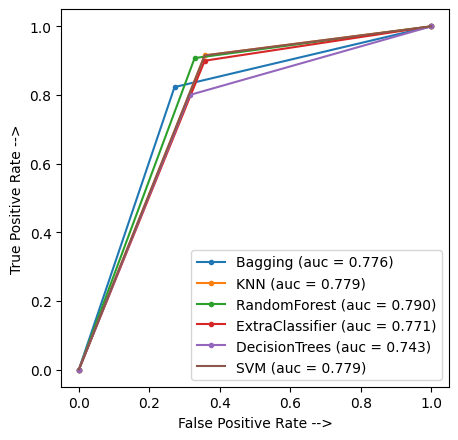

In [47]:
bag_fpr, bag_tpr, threshold = roc_curve(y_test, y_pred_bag)
auc_bag = auc(bag_fpr, bag_tpr)

kn_fpr, kn_tpr, threshold = roc_curve(y_test, y_pred_kn)
auc_kn = auc(kn_fpr, kn_tpr)

rn_fpr, rn_tpr, threshold = roc_curve(y_test, y_pred_rn)
auc_rn = auc(rn_fpr, rn_tpr)

et_fpr, et_tpr, threshold = roc_curve(y_test, y_pred_et)
auc_et = auc(et_fpr, et_tpr)

dt_fpr, dt_tpr, threshold = roc_curve(y_test, y_pred_dt)
auc_dt = auc(dt_fpr, dt_tpr)

svm_fpr, svm_tpr, threshold = roc_curve(y_test, y_pred_svm)
auc_svm = auc(svm_fpr, svm_tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(bag_fpr, bag_tpr, marker='.', label='Bagging (auc = %0.3f)' % auc_bag)
plt.plot(kn_fpr, kn_tpr, marker='.', label='KNN (auc = %0.3f)' % auc_kn)
plt.plot(rn_fpr, rn_tpr, marker='.', label='RandomForest (auc = %0.3f)' % auc_rn)
plt.plot(et_fpr, et_tpr, marker='.', label='ExtraClassifier (auc = %0.3f)' % auc_et)
plt.plot(dt_fpr, dt_tpr, marker='.', label='DecisionTrees (auc = %0.3f)' % auc_dt)
plt.plot(svm_fpr, svm_tpr, linestyle='-', label='SVM (auc = %0.3f)' % auc_svm)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

In [48]:
from statsmodels.tools.eval_measures import rmse

print(rmse(y_test, y_pred_svm))
print(rmse(y_test, y_pred_dt))
print(rmse(y_test, y_pred_bag))
print(rmse(y_test, y_pred_rn))
print(rmse(y_test, y_pred_et))
print(rmse(y_test, y_pred_kn))

0.4242640687119285
0.4898979485566356
0.458257569495584
0.4183300132670378
0.43588989435406733
0.4242640687119285


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Merging both Vital Signs Data & Clinical Notes

In [ ]:
uploaded = files.upload()

In [ ]:
df1 = pd.read_csv('P1_file.csv')
df2 = pd.read_csv('P2_file.csv')
df3 = pd.read_csv('P3_file.csv')
df4 = pd.read_csv('P4_file.csv')

In [ ]:
df1.isnull().values.any()

In [ ]:
result = pd.concat([df1, df2, df3, df4], axis= 1)
result.head()

In [ ]:
results = result.drop(['Unnamed: 0'], axis =1)
results.head()

In [ ]:
X = results.drop(['new_PrimaryDiagnosisName'], axis = 1)
y = results['new_PrimaryDiagnosisName']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 365)

In [ ]:
bag = BaggingClassifier()
bag.fit(X_train,y_train)
kn = KNeighborsClassifier()
kn.fit(X_train,y_train)
rn = RandomForestClassifier()
rn.fit(X_train,y_train)
et = ExtraTreesClassifier()
et.fit(X_train,y_train)
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
svm = SVC()
svm.fit(X_train,y_train)

In [ ]:
y_pred_bag = bag.predict(X_test)
print("Accuracy on test set: ") 
print(accuracy_score(y_test, y_pred_bag))

y_pred_kn = kn.predict(X_test)
print("Accuracy on test set: ") 
print(accuracy_score(y_test, y_pred_kn))

y_pred_rn = rn.predict(X_test)
print("Accuracy on test set: ") 
print(accuracy_score(y_test, y_pred_rn))

y_pred_et = et.predict(X_test)
print("Accuracy on test set: ") 
print(accuracy_score(y_test, y_pred_et))

y_pred_dt = dt.predict(X_test)
print("Accuracy on test set: ") 
print(accuracy_score(y_test, y_pred_dt))

y_pred_svm = svm.predict(X_test)
print("Accuracy on test set: ") 
print(accuracy_score(y_test, y_pred_svm))

In [ ]:
print(classification_report(y_test, y_pred_bag))
print(confusion_matrix(y_test,y_pred_bag))
print(classification_report(y_test, y_pred_kn))
print(confusion_matrix(y_test,y_pred_kn))
print(classification_report(y_test, y_pred_rn))
print(confusion_matrix(y_test,y_pred_rn))
print(classification_report(y_test, y_pred_et))
print(confusion_matrix(y_test,y_pred_et))
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test,y_pred_dt))
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test,y_pred_svm))

In [ ]:
bag_fpr, bag_tpr, threshold = roc_curve(y_test, y_pred_bag)
auc_bag = auc(bag_fpr, bag_tpr)

kn_fpr, kn_tpr, threshold = roc_curve(y_test, y_pred_kn)
auc_kn = auc(kn_fpr, kn_tpr)

rn_fpr, rn_tpr, threshold = roc_curve(y_test, y_pred_rn)
auc_rn = auc(rn_fpr, rn_tpr)

et_fpr, et_tpr, threshold = roc_curve(y_test, y_pred_et)
auc_et = auc(et_fpr, et_tpr)

dt_fpr, dt_tpr, threshold = roc_curve(y_test, y_pred_dt)
auc_dt = auc(dt_fpr, dt_tpr)

svm_fpr, svm_tpr, threshold = roc_curve(y_test, y_pred_svm)
auc_svm = auc(svm_fpr, svm_tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(bag_fpr, bag_tpr, marker='.', label='Bagging (auc = %0.3f)' % auc_bag)
plt.plot(kn_fpr, kn_tpr, marker='.', label='KNN (auc = %0.3f)' % auc_kn)
plt.plot(rn_fpr, rn_tpr, marker='.', label='RandomForest (auc = %0.3f)' % auc_rn)
plt.plot(et_fpr, et_tpr, marker='.', label='ExtraClassifier (auc = %0.3f)' % auc_et)
plt.plot(dt_fpr, dt_tpr, marker='.', label='DecisionTrees (auc = %0.3f)' % auc_dt)
plt.plot(svm_fpr, svm_tpr, linestyle='-', label='SVM (auc = %0.3f)' % auc_svm)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

In [ ]:
print(rmse(y_test, y_pred_svm))
print(rmse(y_test, y_pred_dt))
print(rmse(y_test, y_pred_bag))
print(rmse(y_test, y_pred_rn))
print(rmse(y_test, y_pred_et))
print(rmse(y_test, y_pred_kn))

##Hyperparameter Tuning using GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'C':[ 0.01, 0.1, 1], 'kernel':['linear','rbf','poly']}

In [ ]:
svm1 = SVC()
grid = GridSearchCV(svm1, param_grid)

In [ ]:
grid.fit(X_new, y)

In [ ]:
grid.best_params_

In [ ]:
y_pred_svm_grid = grid.predict(X_test)
print("Accuracy on test set: ") 
print(accuracy_score(y_test, y_pred_svm_grid))

In [ ]:
import seaborn as sns

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot('ED_PLT','ED_HCT')